# BIS634 Homework2_Yining Chen

In [75]:
import sys

first I checked the size of an empty list which yields an answer of 56. The size of a float is 64-56 = 8

In [85]:
a = []

In [86]:
sys.getsizeof(a)

56

In [78]:
b = [1.234]

In [79]:
sys.getsizeof(b)

64

First I used this method to calculate the total memory used as following equation, which yields an answer greater than 4GB but smaller than 8GB

In [80]:
(500 * 1000000 * 8 + 56) * 1e-9

4.000000056

Then I figured maybe python allocates more memory when adding more input in the list (because in Java it would always preallocate memory)\
So I tried to implement the .append( ) method multiple times to see how the memory increases

In [87]:
a.append(1.123)

In [88]:
sys.getsizeof(a)

88

The first three times, it gives a size of 88, then it changes to 120 at the fifth time, 184 at the 9th time, 248 at the 17th time, 312 at the 25th time...

empty list - 56 \
1st append - 88， diff 32\
5th append - 120, diff 32 \
9th append - 184, diff 64\
17th append - 248, diff 64\
25th  append- 312, diff 64 \
.....

From this trend we can see, the more elements are appended in the list, the more memory python would allocate. So we can interpret that, when the elements increased to 500 million, the memory preallocated in the list by .append() would be extremely large, which lead to the MemoryError even with 8GB of RAM

#### A way of storing all the data in memory that would work
Since the list is created first, it allocated a fixed among of memory which is smaller than 8GB

In [ ]:
with open('weights.txt') as f:
    lst = [0 for _ in range(500000000)]
    count = 0
    for line in f:
        count += 1
        lst[count] = float(line)
print("average =", sum(lst) / count)

In [95]:
# test the size of the list
lst = [0 for _ in range(500000000)]
sys.getsizeof(lst)*1e-9

4.343989656000001

#### A way that would not require storing all the data in memory
Do not create a list to store all the data since we only want the average (no need for keeping track of each single value) \
Simply sum them up using the for loop and divide for average instead of creating the list

In [ ]:
with open('weights.txt') as f:
    s = 0
    count = 0
    for line in f:
        s += float(line)
        count += 1
print("average =", s / count)

# 2

In [1]:
from hashlib import sha3_256, sha256, blake2b


class Bloomfilter(object):
    def __init__(self, size=15, hushf_num=3):
        self.size = size
        self.hushf_num = hushf_num
        # we use a list of Booleans to represent our
        # bit array for simplicity
        self.bit_array = [False for i in range(self.size)]

    def my_hash(self, s):
        return int(sha256(s.lower().encode()).hexdigest(), 16) % self.size

    def my_hash2(self, s):
        return int(blake2b(s.lower().encode()).hexdigest(), 16) % self.size

    def my_hash3(self, s):
        return int(sha3_256(s.lower().encode()).hexdigest(), 16) % self.size

    def add(self, s):
        if self.hushf_num == 1:
            digest1 = self.my_hash(s)
            self.bit_array[digest1] = True
        elif self.hushf_num == 2:
            digest1 = self.my_hash(s)
            digest2 = self.my_hash2(s)
            self.bit_array[digest1] = True
            self.bit_array[digest2] = True
        elif self.hushf_num == 3:
            digest1 = self.my_hash(s)
            digest2 = self.my_hash2(s)
            digest3 = self.my_hash3(s)
            self.bit_array[digest1] = True
            self.bit_array[digest2] = True
            self.bit_array[digest3] = True

    def check(self, s):
        if self.hushf_num == 1:
            digest1 = self.my_hash(s)
            if self.bit_array[digest1]:
                return True
        elif self.hushf_num == 2:
            digest1 = self.my_hash(s)
            digest2 = self.my_hash2(s)
            if self.bit_array[digest1] and self.bit_array[digest2]:
                return True
        elif self.hushf_num == 3:
            digest1 = self.my_hash(s)
            digest2 = self.my_hash2(s)
            digest3 = self.my_hash3(s)
            if self.bit_array[digest1] and self.bit_array[digest2] and self.bit_array[digest3]:
                return True
        return False


In [2]:
def spelling_correction(string, data):
    s_lst = list(string)
    ret = []
    for i in range(len(string)):
        for s in range(97, 123):
            s = chr(s)
            if s == string[i]:
                continue
            s_lst[i] = s
            # s_temp is the altered string, to check whether is in the filter
            s_temp = ''.join(s_lst)
            # if in the filter, add to the suggestion list
            if data.check(s_temp):
                ret.append(s_temp)
            s_lst[i] = string[i]
    return ret
    

In [3]:
def judge_good_suggestion(suggestions, correct_word):
    if len(suggestions) > 3:
        return False
    if correct_word in suggestions:
        return True
    return False

In [4]:
data = Bloomfilter(size=int(1e7), hushf_num=3)
with open('desktop/words.txt') as f:
    for line in f:
        word = line.strip()
        data.add(word)

In [5]:
spelling_correction('floeer', data)

['floter', 'flower']

In [48]:
import json
with open('desktop/typos.json') as f:
    json_data = json.load(f)
    
size_lst = [10, 100, 1000, 10000, int(1e5), int(1e6), int(1e7)]
hushf_num_lst = [1, 2, 3]

mis_identified_dict = {}
good_suggestions_dict = {}



for hushf_num in hushf_num_lst:
    mis_identified_dict[hushf_num] = {}
    good_suggestions_dict[hushf_num] = {}
    
    for size in size_lst:
        data = Bloomfilter(size=size, hushf_num=hushf_num)
        with open('desktop/words.txt') as f:
            for line in f:
                word = line.strip()
                data.add(word)
                
        identified_pos = 0
        good_suggestions_count = 0
        
        for (typed_word, correct_word) in json_data:
            if data.check(typed_word):
                identified_pos += 1
            suggestions = spelling_correction(typed_word, data)
            if judge_good_suggestion(suggestions, correct_word):
                good_suggestions_count += 1
                
        mis_identified = identified_pos - len(json_data)/2
        mis_identified_dict[hushf_num][size] = mis_identified
        
        good_suggestions_dict[hushf_num][size] = good_suggestions_count
        

#### Plot the effect of the size of the filter together with the choice of just the first, the first two, or all three of the above hash functions on the number of words misidentified as correct and the number of "good suggestions".

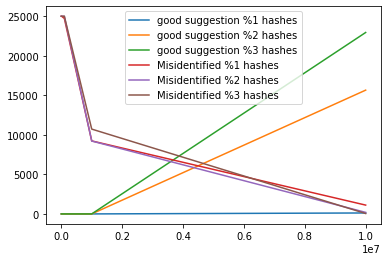

In [67]:
import matplotlib.pyplot as plt

plt.plot(size_lst, [good_suggestions_dict[1][v] for v in size_lst], label = "good suggestion %1 hashes")
plt.plot(size_lst, [good_suggestions_dict[2][v] for v in size_lst], label = "good suggestion %2 hashes")
plt.plot(size_lst, [good_suggestions_dict[3][v] for v in size_lst], label = "good suggestion %3 hashes")
plt.plot(size_lst, [mis_identified_dict[1][v] for v in size_lst], label = "Misidentified %1 hashes")
plt.plot(size_lst, [mis_identified_dict[2][v] for v in size_lst], label = "Misidentified %2 hashes")
plt.plot(size_lst, [mis_identified_dict[3][v] for v in size_lst], label = "Misidentified %3 hashes")
plt.legend()
plt.show()

In this graph, I did not use log-log plot. Because I want to show a more __linear__ trend of how the good suggestion rate increases as n increases and how misidentified number decreases.

In [101]:
for hushf_num in hushf_num_lst:
    flag = False
    for size in size_lst:
        if good_suggestions_dict[hushf_num][size] / 25000 >= 0.9:
            flag = True
            break
    if flag:
        print(hushf_num, "is able to reach 90% acc with the size of", size)
    else:
        print(hushf_num, "can't reach 90% acc with size <= 1e7")

1 can't reach 90% acc with size <= 1e7
2 can't reach 90% acc with size <= 1e7
3 is able to reach 90% acc with the size of 10000000


From the code above, we can see that when using 3 hashing functions, we are able to reach a good suggestion rate of 90% with when using __1e7__ bits to hash.

# 3

In [78]:
class Tree:
    def __init__(self):
        self._value = None
        self.left = None
        self.right = None
        
    def __contains__(self, item):
          if self._value == item:
            return True
          elif self.left and item < self._value:
            return item in self.left
          elif self.right and item > self._value:
            return item in self.right
          else:
            return False
    
    ## the add method
    def add(self, item):
        if not self._value:
            self._value = item
            return
        
        # consolidate two redundant
        if self._value == item:
            return

        if item < self._value:
            if self.left:
                self.left.add(item)
                return
            self.left = Tree()
            self.left.add(item)
            return

        if self.right:
            self.right.add(item)
            return
        self.right = Tree()
        self.right.add(item)

In [79]:
my_tree = Tree()
for item in [55, 62, 37, 49, 71, 14, 17]:
    my_tree.add(item)

Test the __in__ operator by checking whether 55 and 42 are in the tree

In [80]:
55 in my_tree

True

In [81]:
42 in my_tree

False

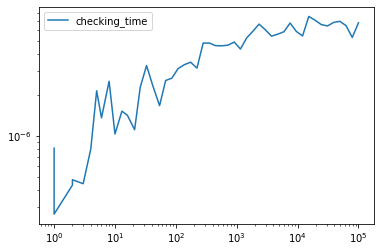

In [77]:
import numpy as np
import time
import matplotlib.pyplot as plt

n_lst = np.logspace(0,5, dtype = int)
check_time = []

for n in n_lst:
    my_tree = Tree()
    lst = np.random.randint(1e4, size = n)
    for item in lst:
        my_tree.add(item)
        
    t_start = time.time()
    
    for i in range(1000):
        i in my_tree
        
    t_stop = time.time()
    check_time.append((t_stop-t_start)/1000)

plt.loglog(n_lst, check_time, label = 'checking_time')
plt.legend()
plt.show()


The log-log plot above takes the log value of checking time (the __containing__ method) as x, and log value of n as y.\
The plot shows a relationship of log trend, which indicates that the containing method has a O(log n) run-time \
When n is relatively large(1e5), we can see that the line is almost horizontal 

#### Provide supporting evidence that the time to setup the tree is O(n log n) by timing it for various sized ns and showing that the runtime lies between a curve that is O(n) and one that is O(n**2)

In [68]:
import numpy as np
import time
import matplotlib.pyplot as plt

n_lst = np.logspace(0,6, dtype = int)
check_time = []

for n in n_lst:
    t_start = time.time()
    my_tree = Tree()
    lst = np.random.randint(1e4, size = n)
    for item in lst:
        my_tree.add(item)
    t_stop = time.time()
    check_time.append((t_stop-t_start))

From the lecture, we know that scaling doesn't affect the run-time analysis (big O)\
So in order to visualize the graph in a better way, I divided the y = n^2 line, and y = n line by 1e6\
In this way, we are able to compare the slope and trend of all three lines in a better way

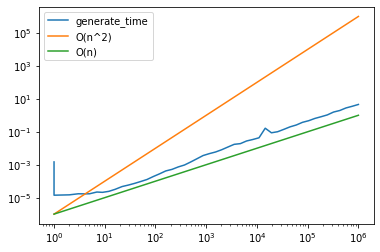

In [71]:
plt.loglog(n_lst, check_time, label = 'generate_time')
# scale the O(n^2) and O(n) by dividing it by 1e6
plt.loglog(n_lst, (np.square(n_lst)/1e6), label = 'O(n^2)')
plt.loglog(n_lst, (n_lst/1e6), label = 'O(n)')
plt.legend()
plt.show()

The log-log plot above takes the log value of Tree setup time as x-axis, and log value of n as y-axis.
The blue line indicates the Tree generation time. The blue line lies between the O(n^2) line and O(n) line.\
So we can properly interpret that the Tree setting process has a __O(n$*$log n)__ run-time

# 4

In [34]:
def alg1(data):
    data = list(data)
    changes = True
    while changes:
        changes = False
        for i in range(len(data) - 1):
            if data[i + 1] < data[i]:
                data[i], data[i + 1] = data[i + 1], data[i]
                changes = True
    return data

In [35]:
def alg2(data):
    if len(data) <= 1:
        return data
    else:
        split = len(data) // 2
        left = iter(alg2(data[:split]))
        right = iter(alg2(data[split:]))
        result = []
        # note: this takes the top items off the left and right piles
        left_top = next(left)
        right_top = next(right)
        while True:
            if left_top < right_top:
                result.append(left_top)
                try:
                    left_top = next(left)
                except StopIteration:
                    # nothing remains on the left; add the right + return
                    return result + [right_top] + list(right)
            else:
                result.append(right_top)
                try:
                    right_top = next(right)
                except StopIteration:
                    # nothing remains on the right; add the left + return
                    return result + [left_top] + list(left)


#### By trying a few tests, hypothesize what operation these functions perform on the list of values.

In [36]:
a = [3,5,2,7,1,3,2,5,7,24,23,12,34]
print(alg1(a))
print(alg2(a))

[1, 2, 2, 3, 3, 5, 5, 7, 7, 12, 23, 24, 34]
[1, 2, 2, 3, 3, 5, 5, 7, 7, 12, 23, 24, 34]


By testing alg1 and alg2 with list a, we can see that both alg1 and alg2 are sorting algorithms, which returns a list with ascending order.

#### Explain how each of these functions is able to complete the task

alg1 is like a bubble sort. This sorting algorithm is completed by repeatedly swapping the adjacent elements that are in the wrong orders.\
alg2 is like a merge sort. This sorting algorithm is completed by the idea of "divide and conquer". It is to recursively break the list into two halves util it's only one or two items, and then appended them together in to the whole list.

In [37]:
#  Lorentz System
def data1(n, sigma=10, rho=28, beta=8/3, dt=0.01, x=1, y=1, z=1):
    import numpy
    state = numpy.array([x, y, z], dtype=float)
    result = []
    for _ in range(n):
        x, y, z = state
        state += dt * numpy.array([
            sigma * (y - x),
            x * (rho - z) - y,
            x * y - beta * z
        ])
        result.append(float(state[0] + 30))
    return result

In [38]:
# in correct order
def data2(n):
    return list(range(n))

In [39]:
# in reversed order
def data3(n):
    return list(range(n, 0, -1))

In [40]:
import numpy as np
from time import perf_counter
import matplotlib.pyplot as plt

n_lst = np.logspace(0,4,dtype = int)

alg1_time = {}
alg2_time = {}

for i in [1,2,3]:
    time1 = []
    time2 = []
    for n in n_lst:
        if i == 1:
            data = data1(int(n))
        elif i == 2:
            data = data2(int(n))
        else:
            data = data3(int(n))
        
        t_start = perf_counter()
        alg1(data)
        t_stop = perf_counter()
        time1.append(t_stop-t_start)
        
        t_start = perf_counter()
        alg2(data)
        t_stop = perf_counter()
        time2.append(t_stop-t_start)
        
        alg1_time[i] = time1
        alg2_time[i] = time2
        
 

#### Plot on a loglog graph as a function of n, and describe the apparent big-O scaling of each

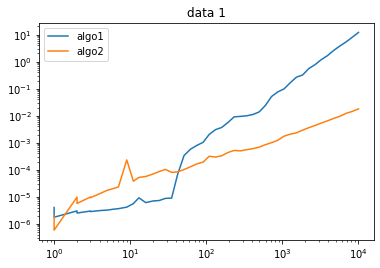

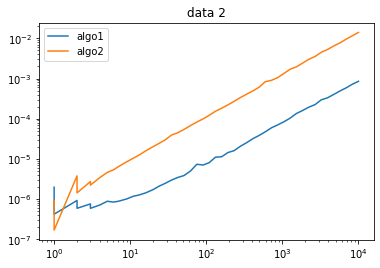

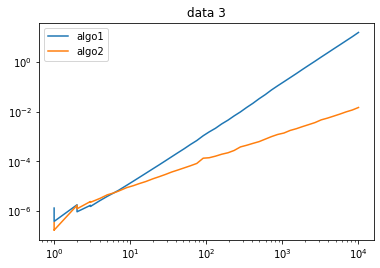

In [46]:
plt.clf()
plt.loglog(n_lst, alg1_time[1], label='algo1')
plt.loglog(n_lst, alg2_time[1], label='algo2')


plt.legend()
plt.title('data 1')
plt.show()

plt.clf()
plt.loglog(n_lst, alg1_time[2], label='algo1')
plt.loglog(n_lst, alg2_time[2], label='algo2')
plt.legend()
plt.title('data 2')
plt.show()

plt.clf()
plt.loglog(n_lst, alg1_time[3], label='algo1')
plt.loglog(n_lst, alg2_time[3], label='algo2')
plt.legend()
plt.title('data 3')
plt.show()

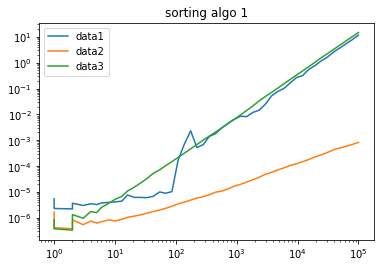

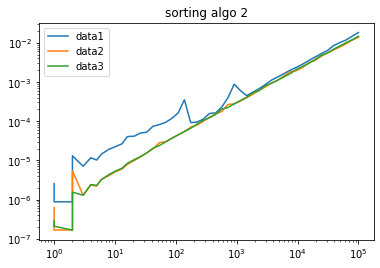

In [83]:
plt.clf()
plt.loglog(n_lst, alg1_time[1], label='data1')
plt.loglog(n_lst, alg1_time[2], label='data2')
plt.loglog(n_lst, alg1_time[3], label='data3')
plt.legend()
plt.title('sorting algo 1')
plt.show()

plt.clf()
plt.loglog(n_lst, alg2_time[1], label='data1')
plt.loglog(n_lst, alg2_time[2], label='data2')
plt.loglog(n_lst, alg2_time[3], label='data3')
plt.legend()
plt.title('sorting algo 2')
plt.show()

For all three data generating methods:
From the above graph, we can interpret that the apparent big-O scaling for alg1 is O(n^2), which matches the result of bubble sort
And the apparent big-O scaling for alg2 is O(n$*$logn), which matches the result of merge sort

#### Discuss how the scaling performance compares across the three data sets. Which algorithm would you recommend to use for arbitrary data and why?

From the above figures, we can see that for the first data set (data1), alg2 perform significantly better than alg1 as the size of list (n) increases. For the second data set (data2), the two algorithms have similar performance trend, and alg1 is faster than alg2. For the last data set (data3), alg2 almost always has a better performanc compares to alg1. \
I would recommend alg2 for an arbitrary list of data. Data1 is a "Lorentz System", which is more like a simulation to generate random data. It's the more "arbitrary" data among this three data sets. From the performance of alg1 and alg2 on data1, we can interpret that for an arbitrary data set, only if when the size is small, would I recommend alg1. Otherwise, alg2 is a more preferable way.

#### Explain in words how to parallelize alg2; that is, where are there independent tasks whose results can be combined?

As alg2 is a merge sort algorithm, the list is alway splitted into two halves. So we can use this characteristic to implement multiprocessing. The two independent tasks are the left half of the list and the right half of the list. With multiprocessing, the two halves of lists can be sorted independently and parallely. After the sorting processes, we can merge those two halves together. 

#### Using the multiprocessing module, provide a two-process parallel implementation of alg2

In [ ]:
import numpy as np
from time import perf_counter
import matplotlib.pyplot as plt
import multiprocessing

#  Lorentz System
def data1(n, sigma=10, rho=28, beta=8/3, dt=0.01, x=1, y=1, z=1):
    import numpy
    state = numpy.array([x, y, z], dtype=float)
    result = []
    for _ in range(n):
        x, y, z = state
        state += dt * numpy.array([
            sigma * (y - x),
            x * (rho - z) - y,
            x * y - beta * z
        ])
        result.append(float(state[0] + 30))
    return result



def alg2(data):
    if len(data) <= 1:
        return data
    else:
        split = len(data) // 2
        left = iter(alg2(data[:split]))
        right = iter(alg2(data[split:]))
        result = []
        # note: this takes the top items off the left and right piles
        left_top = next(left)
        right_top = next(right)
        while True:
            if left_top < right_top:
                result.append(left_top)
                try:
                    left_top = next(left)
                except StopIteration:
                    # nothing remains on the left; add the right + return
                    return result + [right_top] + list(right)
            else:
                result.append(right_top)
                try:
                    right_top = next(right)
                except StopIteration:
                    # nothing remains on the right; add the left + return
                    return result + [left_top] + list(left)

def merge(left, right):
    left = iter(left)
    right = iter(right)
    result = []
    # note: this takes the top items off the left and right piles
    left_top = next(left)
    right_top = next(right)
    while True:
        if left_top < right_top:
            result.append(left_top)
            try:
                left_top = next(left)
            except StopIteration:
                # nothing remains on the left; add the right + return
                return result + [right_top] + list(right)
        else:
            result.append(right_top)
            try:
                right_top = next(right)
            except StopIteration:
                # nothing remains on the right; add the left + return
                return result + [left_top] + list(left)


#%%
if __name__ == '__main__':
    
    n_lst = [10, 1000, 10000, 10000, 1000000, 10000000]
    time1 = []
    time2 = []

    for n in n_lst:
        print('n = ' + str(n))
        data = data1(n)
        
        t_start = perf_counter()

        with multiprocessing.Pool(2) as pool:
            sor = pool.map(alg2, [data[:len(data)//2],data[len(data)//2:]])
            merge(sor[0],sor[1])
        t_stop = perf_counter()
        print('multi_threading alg2')
        print(t_stop-t_start)
        print('')
        time1.append(t_stop-t_start)
        
        t_start = perf_counter()
        ret2 = alg2(data)
        t_stop = perf_counter()
        print('original alg2')
        print(t_stop-t_start)
        print('')
        time2.append(t_stop-t_start)


    plt.plot(n_lst, time1, label='multiprocessing')
    plt.plot(n_lst, time2, label='original')
    plt.legend()
    plt.title('data 1')
    plt.show()


Note: the above code can not run in Jupyter Notebook. The following outputs are generated by Visual Studio Code.

![](multi_original.png)

![](p4.png)

#### Compare its performance on data from the data1 function for moderate n, and discuss your findings

From the Above graphs, we can see that when the size of input list is relatively small, for example when n <= 1e4, the original way is faster than multiprocessing. However, as the size n increases, the performance of multiprocessing method increase significantly, with an approximate two time faster performance than the original method.